##### Arbitrage strategy involving UNG, EQT and RRC (5 years daily data from yahoo)

Since UNG prices affect EQT and RRC prices, I have created created a long short strategy that trades on the spread between UNG-EQT and UNG-RRC. To create a trading signal, I have created a deviation from spread.
Spread has been calculated in two ways: 

First by looking at the value of $$ Asset1/Asset2$$


Secondly by doing a least sqaures regression between the dependent variable (EQT/RRC) with the independent variable (UNG). Then using $\beta $ coeeficient of the regression to calculate the spread as 
$$Asset1 - \beta * Asset2$$

Deviation from the spread is measured by Zscore and is used to generate a trading signal. Zscore has been normalized by subtracting rolling window mean of the spread (to remove lookahead bias) and divding by rolling window standard deviation of the spread. Anytime Zscore exceeds a threshold, I short the first asset and go long on the second asset. If Zscore goes below a certain threshold, I go short on the first asset and long on the second asset. 

I have tried to see different length windows periods to see which perform best and also which of the two spreads perform better. 

Finally I have created a portfolio position to keep track of all position(long,short,exits) and calculated daily cumulative returns. I have ignored risk free rate while calculating sharpe ratio and calculated it as

$$MEAN(Daily Returns) * \sqrt(252)/ STDEV(Daily Returns)$$

The strategy with UNG-RRC involing spread with least regression has a sharpe ratio of 0.90.



In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
pd.options.mode.chained_assignment = None

##### Read the data

In [15]:
def read_data(pd_frame):
    data = pd.read_csv(pd_frame, header=0)
    data = data.iloc[::-1]
    data = data.set_index('Date')
    data.name = pd_frame[-7:-4]
    return data

##### Combine the two assets 

In [16]:
def combine_eqts(data1, data2):
      
    stk1 = read_data(data1)
    stk2 = read_data(data2)
    data = pd.DataFrame(index=stk1.index)
    data[stk1.name.lower()] = stk1['Adj Close']
    data[stk2.name.lower()] = stk2['Adj Close']
    return data

#####  Calculate spread by $Asset1/Asset2$ and the get Zscore

In [17]:
def simple_z_score(data, roll_history=40, roll_current=5):
    spread_hist = data.iloc[:,0] / data.iloc[:,1]
    spread_hist_mean = spread_hist.rolling(window=roll_history).mean()
    spread_hist_std = spread_hist.rolling(window=roll_history).std()
    
    spread_curr = data.iloc[roll_history::,0] / data.iloc[roll_history::,1]
    spread_curr_mean = spread_curr.rolling(window=roll_current).mean()
    zscore = (spread_curr_mean - spread_hist_mean)/spread_hist_std
    
    data['spread'] = spread_curr_mean
    data['zscore'] = zscore
    data = data.dropna()
    return data

#####  Calculate spread by moving window least sqaures regression and the get Zscore

In [18]:
def regression_zscore(data, rolling_window=100):
      
    #print "Rolling Least squares Regression"
    model = pd.stats.ols.MovingOLS(y=data.iloc[:,0], 
                   x=data.iloc[:,1], window_type = 'rolling', window=rolling_window,intercept=False)
    data['ratio'] = model.beta['x']
    data = data.dropna()

    data['spread'] = data.iloc[:,0] - data['ratio']*data.iloc[:,1]
    #data['zscore'] = (data['spread'] - np.mean(data['spread']))/np.std(data['spread'])
    
    spread_curr_mean = data['spread'].rolling(window=4).mean()
    spread_curr_std = data['spread'].rolling(window=4).std()
    data['zscore'] = (data['spread'] - spread_curr_mean)/spread_curr_std
    data = data.dropna()
    return data

##### Use Zscore for signal generation and to get into long/short position. Entry threshold decides when to enter a position and exit decides when to leave a position

In [19]:
def signal_generation(data, entry_threshold=2.0, exit_threshold=1.0):
   
    data['longs'] = (data['zscore'] <= -entry_threshold)*1.0
    data['shorts'] = (data['zscore'] >= entry_threshold)*1.0
    data['exits'] = (np.abs(data['zscore']) <= exit_threshold)*1.0

    data['long_market'] = 0.0
    data['short_market'] = 0.0

    long_market = 0
    short_market = 0

    #When to be in long and short and exit
    for i, b in enumerate(data.iterrows()):
        # longs
        if b[1]['longs'] == 1.0:
            long_market = 1            
        # shorts
        if b[1]['shorts'] == 1.0:
            short_market = 1
        # exists
        if b[1]['exits'] == 1.0:
            long_market = 0
            short_market = 0
        data.ix[i]['long_market'] = long_market
        data.ix[i]['short_market'] = short_market
    return data

######  Keep track of positions and calculate daily cumulative returns. 

In [20]:
def portfolio_returns(data):
  
    stk1 = data.columns.values[0]
    stk2 = data.columns.values[1]

    portfolio = pd.DataFrame(index=data.index)
    portfolio['positions'] = data['long_market'] - data['short_market']
    portfolio[stk1] = 1.0 * data.iloc[::,0] * portfolio['positions']
    portfolio[stk2] = -1.0 * data.iloc[::,1] * portfolio['positions']
    
    portfolio['total'] = portfolio[stk1] + portfolio[stk2]

    # Calculate returns and remove nans,infinity values 
    
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1.0, 0.0, inplace=True)
    
    # Calculate cumulative return
    portfolio['cum returns'] = (portfolio['returns'] + 1.0).cumprod()
    #Annualized return
    #portfolio['anuualized_return'] = (portfolio['returns'] + 1.0)**365-1
    sharpe_ratio = (portfolio['returns'].mean()*np.sqrt(252))/portfolio['returns'].std()
    
    return portfolio,sharpe_ratio

###### Results

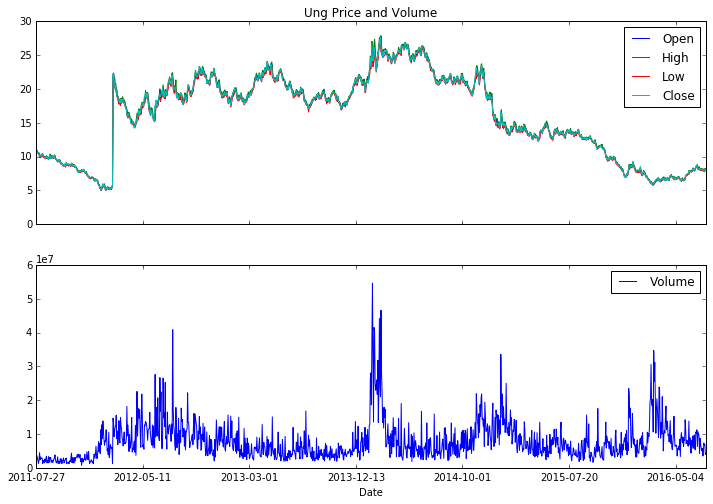

In [21]:
ung = read_data('data/ung.csv')
fig, axes = plt.subplots(nrows=2, ncols=1, sharex = True)
ung[["Open", "High","Low","Close"]].plot(ax=axes[0], x_compat=True, title = 'Ung Price and Volume')
ung[["Volume"]].plot(ax=axes[1])

##### Adj Close Price of ung, etq and rrc

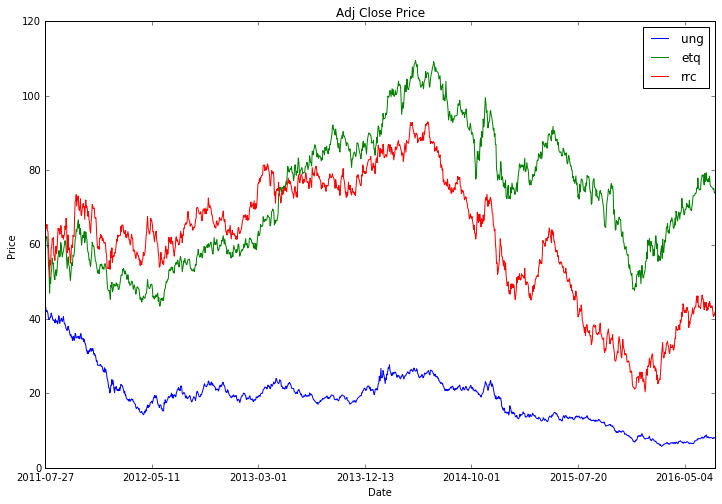

In [22]:
two_assets1 = combine_eqts('data/ung.csv', 'data/etq.csv')
two_assets2 = combine_eqts('data/ung.csv', 'data/rrc.csv')
ax = two_assets1.iloc[::,0].plot(legend=True, title='Adj Close Price')
ax.set_ylabel('Price')
two_assets1.iloc[::,1].plot(ax=ax, legend=True)
two_assets2.iloc[::,1].plot(ax=ax, legend=True)
# # lines, labels = ax.get_legend_handles_labels()
# # labels = ['etq','ung','rrc']
# # ax.legend(lines, labels, loc='best')

##### Sharpe ratio for RRC and UNG spread with least squares regression (strategy 1). UNG is independent variable

In [23]:
two_assets = combine_eqts('data/rrc.csv', 'data/ung.csv')
two_assets = regression_zscore(two_assets,rolling_window=45)
two_assets = signal_generation(two_assets, entry_threshold=1.4, exit_threshold=1)
#del portfolio
portfolio, sharpe_ratio = portfolio_returns(two_assets)
print 'Sharpe ratio for %s and %s strategy is %f' % ( portfolio.columns.values[1], portfolio.columns.values[2],sharpe_ratio)

two_assets.to_excel('two_assets_rrc_ung.xlsx')
portfolio.to_excel('portfolio_rrc_ung.xlsx')

Sharpe ratio for rrc and ung strategy is 0.907451


##### Figure showing Zscore, daily return and cumulative daily return for strategy 1

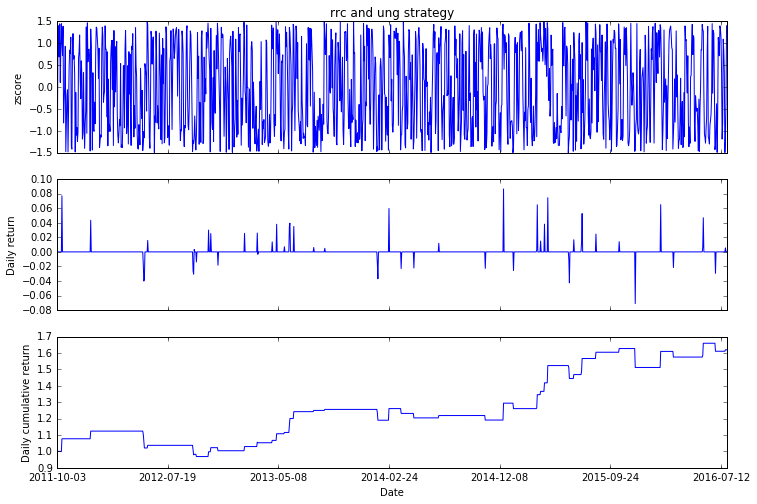

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex = True)
ax = two_assets['zscore'].plot(ax=axes[0], x_compat=True, 
                          title = '%s and %s strategy' % (portfolio.columns.values[1], portfolio.columns.values[2]))
ax.set_ylabel('zscore')
ax = portfolio['returns'].plot(ax=axes[1], x_compat=True )

ax.set_ylabel('Daily return')

ax = portfolio['cum returns'].plot(ax=axes[2]) 
ax.set_ylabel('Daily cumulative return')
                          

##### Sharpe ratio for UNG/ETQ spread (strategy 2)

In [25]:
two_assets = combine_eqts('data/ung.csv', 'data/etq.csv')
two_assets = simple_z_score(two_assets, 30, 1)
two_assets = signal_generation(two_assets, entry_threshold=1.4, exit_threshold=1)
#del portfolio
portfolio, sharpe_ratio = portfolio_returns(two_assets)
print 'Sharpe ratio for %s and %s strategy is %f' % ( portfolio.columns.values[1], portfolio.columns.values[2],sharpe_ratio)

two_assets.to_excel('two_assets_ung_etq.xlsx')
portfolio.to_excel('portfolio_ung_etq.xlsx')

Sharpe ratio for ung and etq strategy is 0.353621


##### Figure showing Zscore, daily return and cumulative daily return for strategy 2

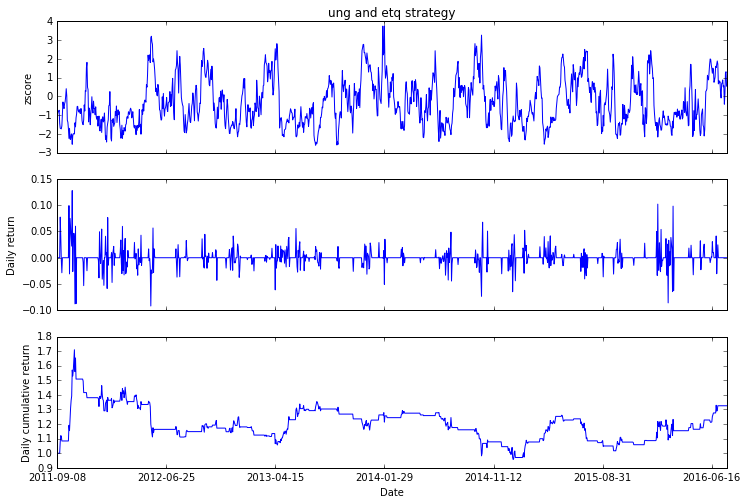

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex = True)
ax = two_assets['zscore'].plot(ax=axes[0], x_compat=True, 
                          title = '%s and %s strategy' % (portfolio.columns.values[1], portfolio.columns.values[2]))
ax.set_ylabel('zscore')
ax = portfolio['returns'].plot(ax=axes[1], x_compat=True )

ax.set_ylabel('Daily return')

ax = portfolio['cum returns'].plot(ax=axes[2]) 
ax.set_ylabel('Daily cumulative return')
                          